# Project 1: End-to-End Pipeline to Classify News Articles

Owner:

Wenxin Cheng	706070535    wenxin0319@g.ucla.edu

Yuxin Yin		606073780    yyxyy999@g.ucla.edu

Yingqian Zhao	306071513    zhaoyq99@g.ucla.edu

## 0 pre-install packages

In [1]:
# !pip install nltk
# !pip install sklearn
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install umap-learn
# !pip install umap-learn[plot]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Question 1

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import umap.plot as uplot
import umap.umap_ as umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import collections
import re
import math
import string
from tqdm import tqdm, trange
from statistics import mean
from sklearn.model_selection import train_test_split 

import nltk
from joblib import Memory
from shutil import rmtree
import seaborn as sns

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag, word_tokenize, sent_tokenize
from nltk.corpus import wordnet
from tqdm import tqdm,tqdm_pandas
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn import svm
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF,TruncatedSVD

np.random.seed(42)
random.seed(42)


df = pd.read_csv("./Project1-Classification.csv")

# How many rows (samples) and columns (features) are present in the dataset?
row_count, column_count = df.shape
print(f'Number of rows: {row_count}, Number of columns: {column_count}')


[nltk_data] Downloading package punkt to C:\Users\wenxin
[nltk_data]     cheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wenxin cheng\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\wenxin
[nltk_data]     cheng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\wenxin
[nltk_data]     cheng\AppData\Roaming\nltk_data...


Number of rows: 3150, Number of columns: 8


min length of characers: 39, max length of characers: 80321, average length of characers: 2682.037142857143


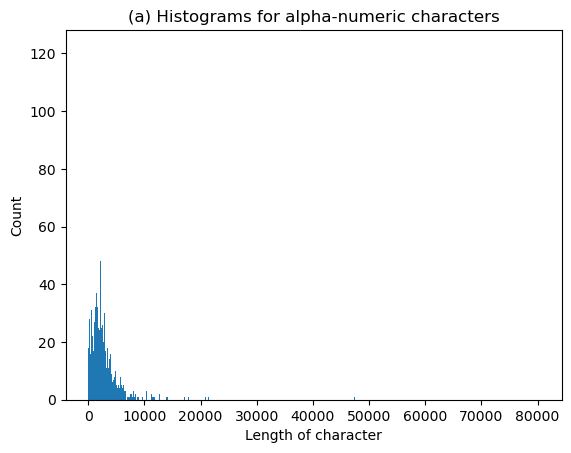

In [10]:
# Histograms: Plot 3 histograms on : 
# (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;
patterns = '[a-zA-Z0-9_]'  # use regular expressions
characters = [len(re.findall(patterns, df['full_text'][i])) for i in range(row_count)]
print(f'min length of characers: {min(characters)}, max length of characers: {max(characters)}, average length of characers: {mean(characters)}')

plt.hist(characters, bins=len(set(characters)))
plt.title("(a) Histograms for alpha-numeric characters")
plt.xlabel("Length of character")
plt.ylabel("Count")
plt.show()

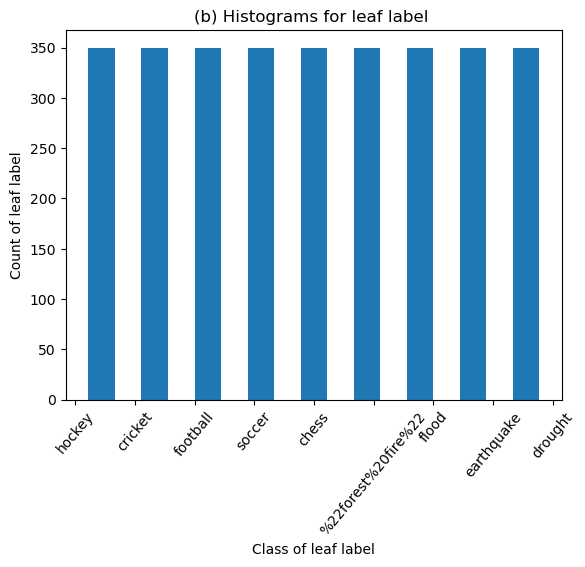

In [11]:
# (b) The column leaf label – class on the x-axis; 
leaf = df["leaf_label"].value_counts()
# print(leaf)
plt.hist(df["leaf_label"], bins = len(leaf), rwidth = 0.5)
plt.xticks(rotation=50)
plt.title("(b) Histograms for leaf label ")
plt.xlabel("Class of leaf label")
plt.ylabel("Count of leaf label")
plt.show()

sports     1750
climate    1400
Name: root_label, dtype: int64


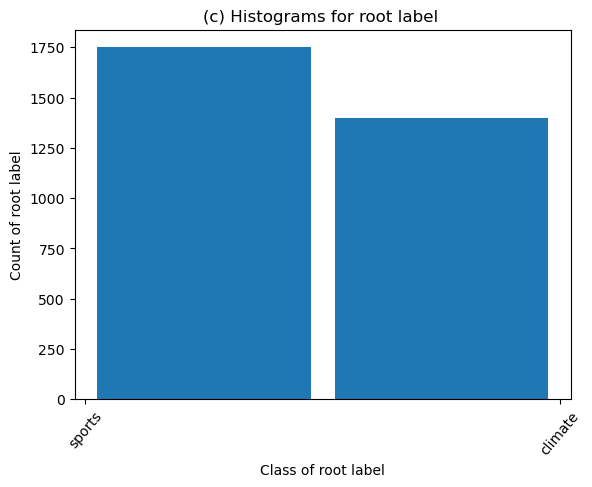

In [12]:
# (c) The column root label – class on the x-axis.
root = df["root_label"].value_counts()
print(root)
plt.hist(df["root_label"], bins = len(root),rwidth = 0.9)
plt.xticks(rotation=50)
plt.title("(c) Histograms for root label ")
plt.xlabel("Class of root label")
plt.ylabel("Count of root label")
plt.show()

## 1  Splitting the entire dataset into training and testing data
### Question 2

In [13]:
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

print(f'Training Samples: {len(train)}, Testing Samples: {len(test)}')

Training Samples: 2520, Testing Samples: 630


## 2 Feature Extraction
### Question 3

In [14]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def remove_numbers(text):
    text_nonum = re.sub(r'\b[0-9]+\b\s*', '', text)
    clean_text = []
    for word in word_tokenize(text):
        if (not any(char.isdigit() for char in word)):
            clean_text.append(word)
    return ' '.join(clean_text)

def penn2morphy(penntag):   # Borrowed from the practice of stackoverflow
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def clean_data(text):  # previous function__clean data
    text = clean(text)
    text = remove_numbers(text)
    return text

def stem(text):
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in word_tokenize(text):
        if (not any(char in word for char in string.punctuation)):
            stemmed_words.append(stemmer.stem(word))
    return ' '.join(stemmed_words)


def lemmatized(text):
    lemmatizer = WordNetLemmatizer()

    sent_pos_tags = [pos_tag(word_tokenize(sent)) for sent in sent_tokenize(text)]
    pos_tags = []
    for sentence_tags in sent_pos_tags:
        for tags in sentence_tags:
            pos_tags.append(tags)
    
    lemmatized_words = []
    lemm_text = [lemmatizer.lemmatize(word, pos = penn2morphy(tag)) for word, tag in pos_tags]
    for lemma in lemm_text:
        if (not any(char in lemma for char in string.punctuation)):
            lemmatized_words.append(lemma.lower())
    return ' '.join(lemmatized_words)

def preprocessing(text):
    text = clean(text)
    text = remove_numbers(text)
    text = lemmatized(text)
    return text

In [15]:
tqdm.pandas() # require pandas == 1.3.5 and tqdm > 4.50.1
train['clean_data'] = train['full_text'].progress_apply(lambda x:preprocessing(x))

100%|██████████| 2520/2520 [01:10<00:00, 35.98it/s]


In [16]:
test['clean_data'] = test['full_text'].progress_apply(lambda x:preprocessing(x))

100%|██████████| 630/630 [00:18<00:00, 34.09it/s]


In [17]:
train.head()

,full_text,root_label,clean_data
2310,"'As of Sunday night, a lopsided area of low pr...",climate,of sunday night a lopsided area of low pressur...
2189,'The U.N. children’s agency says some 2 millio...,climate,childrens agency say some million child in are...
2304,'Wicked winds and heavy rains battered the sta...,climate,wind and heavy rain batter the state of maine ...
2988,'I live in a community with a homeowners assoc...,climate,i live in a community with a homeowner associa...
221,'The Special Olympics team took home the hard ...,sports,special olympics team take home the hard fough...


In [18]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=3)
tfidf_tranformer = TfidfTransformer(use_idf=True)

train_count_vectorizer = count_vectorizer.fit_transform(train['clean_data'])
train_tf_idf3 = tfidf_tranformer.fit_transform(train_count_vectorizer).toarray()
print('train matrix shape:', train_tf_idf3.shape)

test_count_vectorizer = count_vectorizer.transform(test['clean_data'])
test_tf_idf3 = tfidf_tranformer.transform(test_count_vectorizer).toarray()
print('test matrix shape:', test_tf_idf3.shape)

train matrix shape: (2520, 14076)
test matrix shape: (630, 14076)


In [19]:
def show_influence_of_min_df(min_df, train, test):
    count_vectorizer = CountVectorizer(stop_words="english", min_df=min_df)
    tfidf_tranformer = TfidfTransformer(use_idf=True)
    
    train_count_vectorizer = count_vectorizer.fit_transform(train['clean_data'])
    train_tf_idf = tfidf_tranformer.fit_transform(train_count_vectorizer).toarray()
    
    test_count_vectorizer = count_vectorizer.transform(test['clean_data'])
    test_tf_idf = tfidf_tranformer.transform(test_count_vectorizer).toarray()
    
    print(f"when min_df = {min_df}")
    print('train matrix shape:', train_tf_idf.shape)
    print('test matrix shape:', test_tf_idf.shape)
    print()
    return train_tf_idf, test_tf_idf

for i in range(1, 10):
    show_influence_of_min_df(i, train, test)

when min_df = 1
train matrix shape: (2520, 34769)
test matrix shape: (630, 34769)

when min_df = 2
train matrix shape: (2520, 19362)
test matrix shape: (630, 19362)

when min_df = 3
train matrix shape: (2520, 14076)
test matrix shape: (630, 14076)

when min_df = 4
train matrix shape: (2520, 11330)
test matrix shape: (630, 11330)

when min_df = 5
train matrix shape: (2520, 9644)
test matrix shape: (630, 9644)

when min_df = 6
train matrix shape: (2520, 8565)
test matrix shape: (630, 8565)

when min_df = 7
train matrix shape: (2520, 7412)
test matrix shape: (630, 7412)

when min_df = 8
train matrix shape: (2520, 6747)
test matrix shape: (630, 6747)

when min_df = 9
train matrix shape: (2520, 6219)
test matrix shape: (630, 6219)



## 3 Dimensionality Reduction
### Question 4

  0%|          | 0/8 [00:00<?, ?it/s]

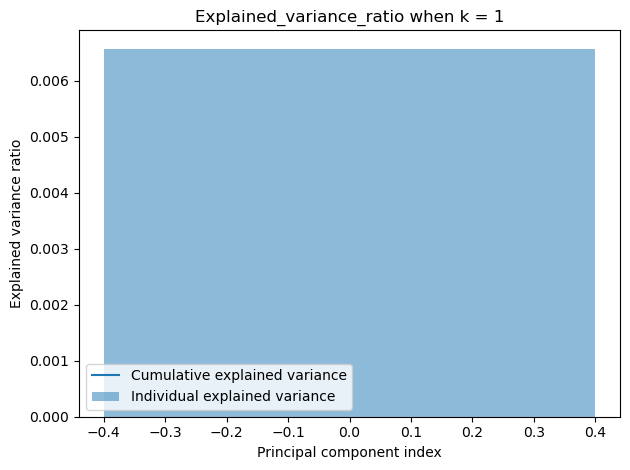

 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

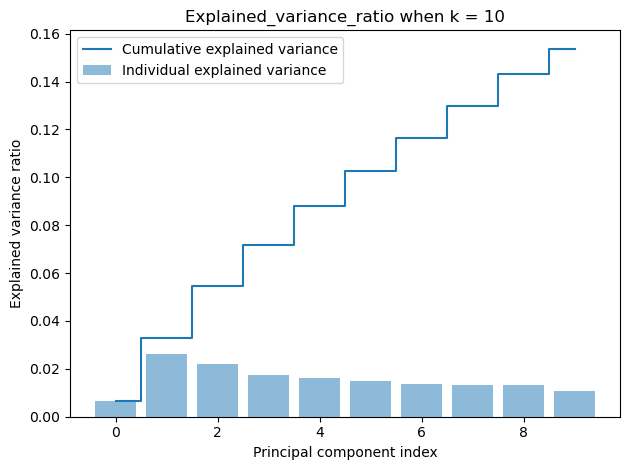

 25%|██▌       | 2/8 [00:01<00:03,  1.81it/s]

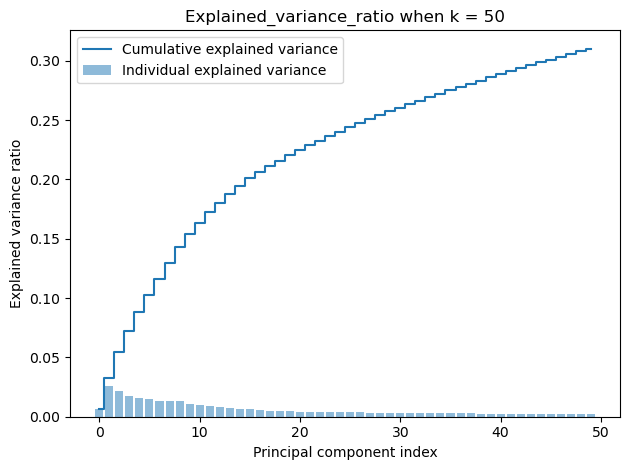

 38%|███▊      | 3/8 [00:01<00:03,  1.44it/s]

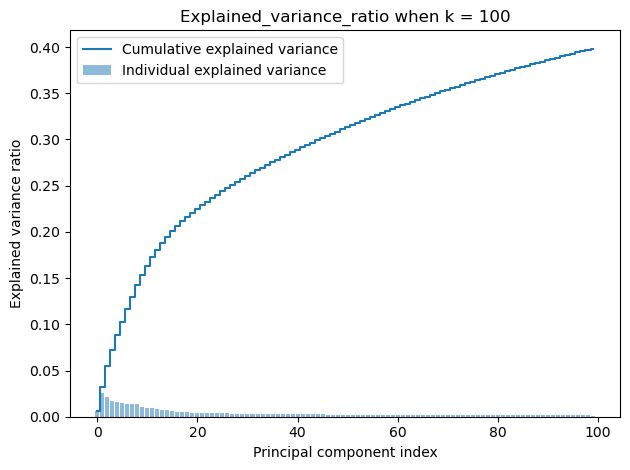

 50%|█████     | 4/8 [00:03<00:03,  1.07it/s]

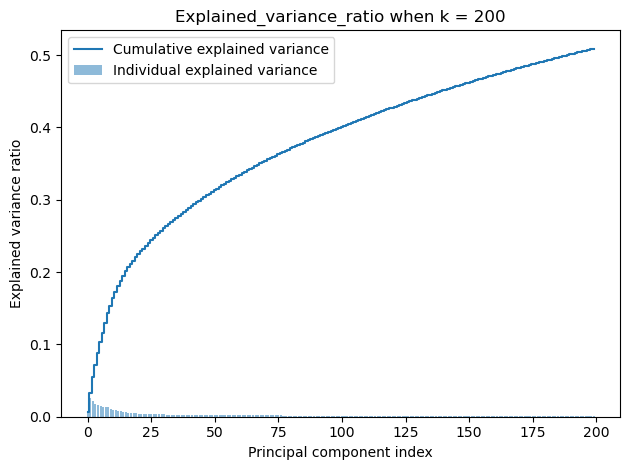

 62%|██████▎   | 5/8 [00:05<00:04,  1.52s/it]

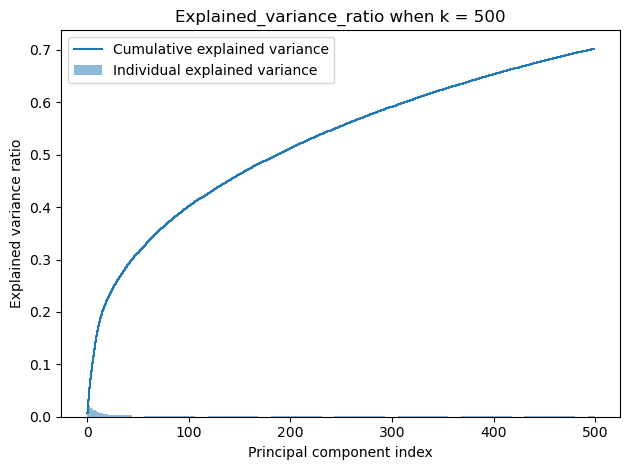

 75%|███████▌  | 6/8 [00:11<00:05,  2.95s/it]

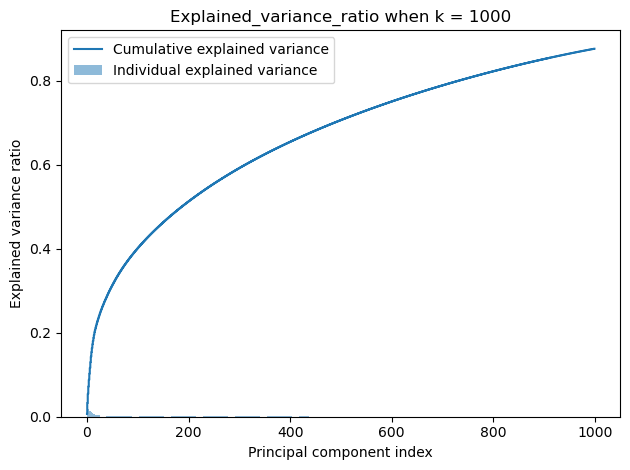

 88%|████████▊ | 7/8 [00:25<00:06,  6.43s/it]

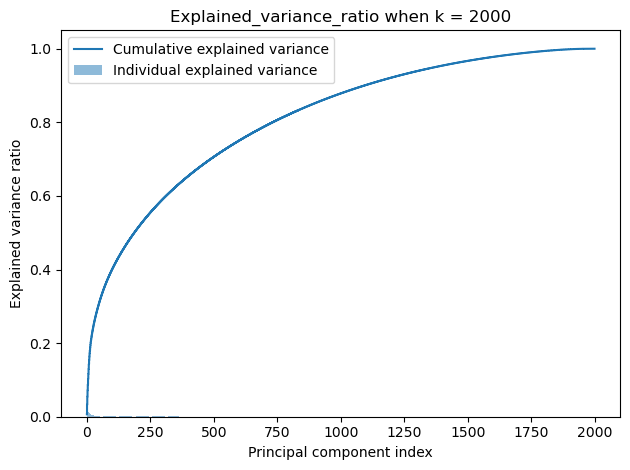

100%|██████████| 8/8 [00:55<00:00,  6.92s/it]


In [20]:
from sklearn.decomposition import TruncatedSVD

k = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratio = []

def plot_figure_for_each_k(k, svd_t):
    exp_var_pca = svd_t.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.title(f"Explained_variance_ratio when k = {k}")
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()    


for i in trange(len(k)):
    svd_t = TruncatedSVD(n_components=k[i], random_state=42)
    svd_t.fit(train_tf_idf3)
    plot_figure_for_each_k(k[i], svd_t)
    explained_variance_ratio.append(sum(svd_t.explained_variance_ratio_))

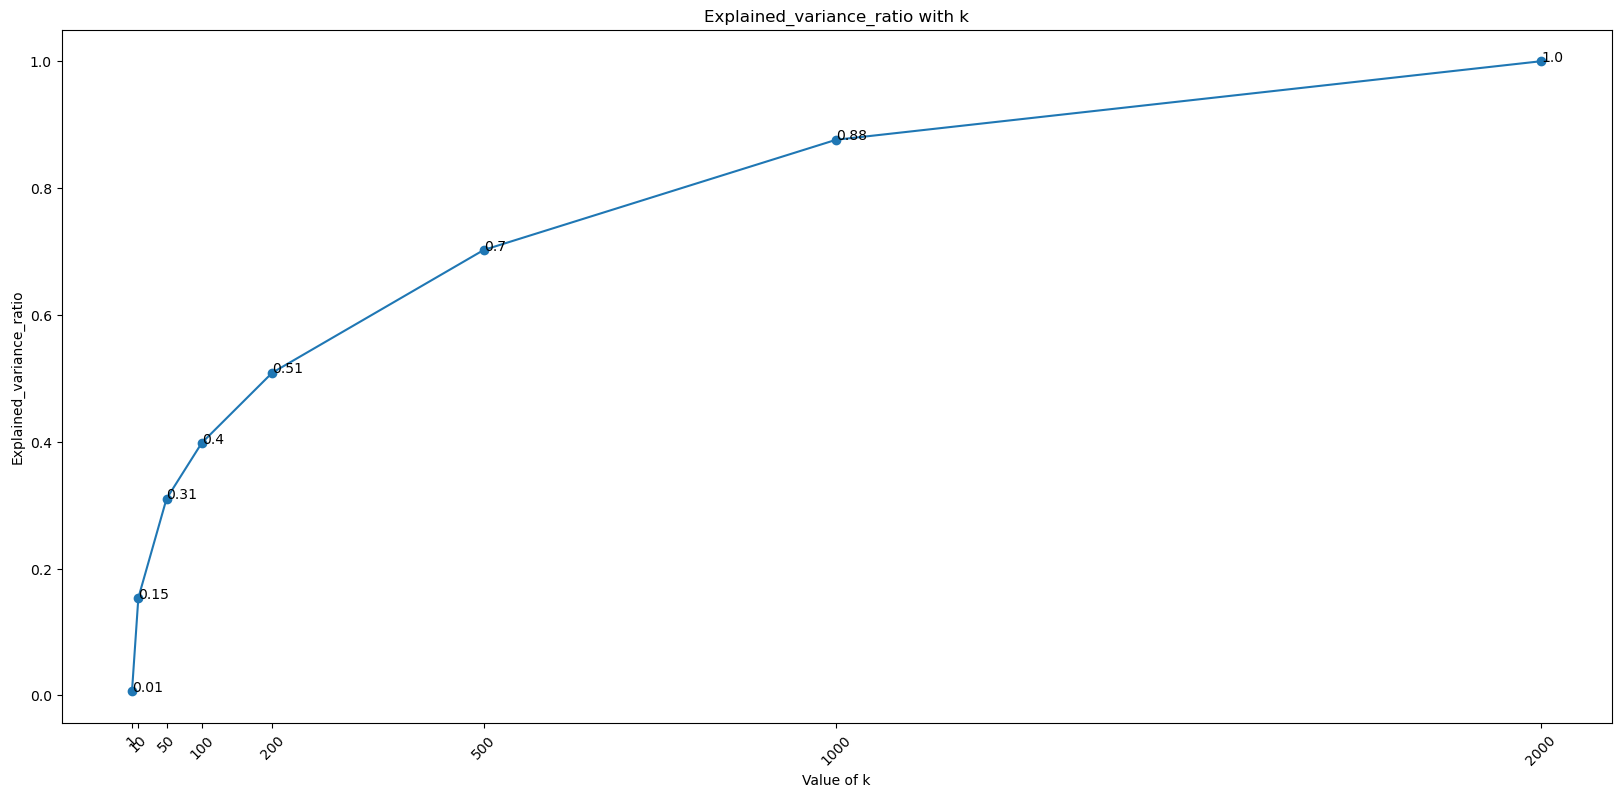

In [21]:
plt.figure(figsize=(20,9))   
plt.title('Explained_variance_ratio with k')
plt.xlabel("Value of k")
plt.ylabel("Explained_variance_ratio")

plt.xticks(k, rotation = 45)    

plt.plot(k, explained_variance_ratio, ls="-", marker="o", label="points")

for ks, exp in zip(k, explained_variance_ratio):
      plt.text(ks, exp, str(round(exp, 2)))
plt.show()

In [22]:
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF

#calculate MSE Error for LSI
u,sigma,vt = randomized_svd(train_tf_idf3,n_components=50,random_state=42) 
X = np.dot(np.dot(u,np.diag(sigma)),vt)
lsi_mse = np.sqrt(np.sum(np.square(X - train_tf_idf3)))
print("MSE Error for LSI is " + str(lsi_mse))

#calculate MSE Error for NMF
nmf = NMF(n_components=50, init='random', random_state=42, max_iter=10000)
nmf_train = nmf.fit_transform(train_tf_idf3)

WH = np.dot(nmf_train, nmf.components_)
nmf_mse = np.sqrt(np.sum(np.square(train_tf_idf3-WH)))
print("MSE Error for NMF is " + str(nmf_mse))

if lsi_mse > nmf_mse:
    print("MSE Error for LSI is larger")
else:
    print("MSE Error for NMF is larger")

MSE Error for LSI is 41.02637078289104
MSE Error for NMF is 41.37286730025996
MSE Error for NMF is larger


## 4 Classification Algorithms
### Question 5

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn import svm
from sklearn.svm import SVC, LinearSVC

def print_result(y_true,y_pred,name="",average='binary'):
    accuracy, recall, precision, f1 = accuracy_score(y_true,y_pred) * 100, recall_score(y_true,y_pred,average=average)*100, \
                                       precision_score(y_true,y_pred,average=average)*100, f1_score(y_true,y_pred,average=average)*100
    print("%s: accuracy= %.2f, recall= %.2f, precision= %.2f, f1= %.2f" %(name,accuracy, recall, precision, f1))

In [24]:
maps= {'sports': 1, 'climate': 0}

lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
data_train = lsi.fit_transform(train_tf_idf3)
data_test = lsi.transform(test_tf_idf3)

train_svm = train
train_svm = train_svm.replace({'root_label': maps})
train_svm_label = train_svm['root_label'].to_numpy()
print(f"train_svm_label shape={train_svm_label.shape}")

test_svm = test
test_svm = test_svm.replace({'root_label': maps})
test_svm_label = test_svm['root_label'].to_numpy()
print(f"test_svm_label shape={test_svm_label.shape}")

train_svm_label shape=(2520,)
test_svm_label shape=(630,)


In [25]:
data_train

array([[ 0.19755883, -0.03736612, -0.11912469, ...,  0.01875285,
        -0.09322906,  0.02818938],
       [ 0.22074995, -0.04018726, -0.13253407, ...,  0.02999147,
        -0.03081749, -0.02817852],
       [ 0.17397403, -0.03626678, -0.10439622, ..., -0.00704109,
        -0.02449883, -0.03470709],
       ...,
       [ 0.10410811, -0.00685205, -0.04026266, ..., -0.05630988,
         0.10427197, -0.08878552],
       [ 0.17156841, -0.01355173,  0.12696069, ..., -0.05282669,
         0.18055011, -0.04410289],
       [ 0.16697223, -0.02561847,  0.11055903, ...,  0.016979  ,
        -0.00699997, -0.00922583]])

In [26]:
# Computing Hard and Soft Margin SVMs
HardMargin_SVM = LinearSVC(C=1000, random_state=42)
HardMargin_SVM2 = LinearSVC(C=100000, random_state=42)
SoftMargin_SVM = LinearSVC(C=0.0001, random_state=42)

X_hardSVM_pred = HardMargin_SVM.fit(data_train,train_svm_label).predict(data_test) # predicting labels for hard margin SVM
X_hardSVM_pred2 = HardMargin_SVM2.fit(data_train,train_svm_label).predict(data_test) # predicting labels for hard margin SVM
X_softSVM_pred = SoftMargin_SVM.fit(data_train,train_svm_label).predict(data_test) # predicting labels for soft margin SVM

print_result(test_svm_label,X_hardSVM_pred, "hard margin svm C=1000" )
print_result(test_svm_label,X_hardSVM_pred2, "hard margin svm C=100000" )
print_result(test_svm_label,X_softSVM_pred, "soft margin svm C=0.0001" )

hard margin svm C=1000: accuracy= 96.67, recall= 97.28, precision= 97.01, f1= 97.14
hard margin svm C=100000: accuracy= 90.32, recall= 100.00, precision= 85.75, f1= 92.33
soft margin svm C=0.0001: accuracy= 58.25, recall= 100.00, precision= 58.25, f1= 73.62


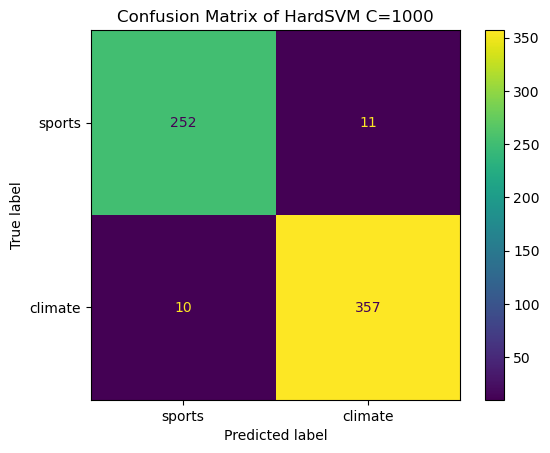

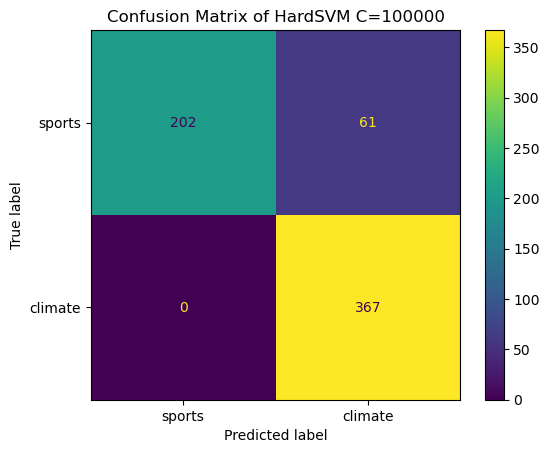

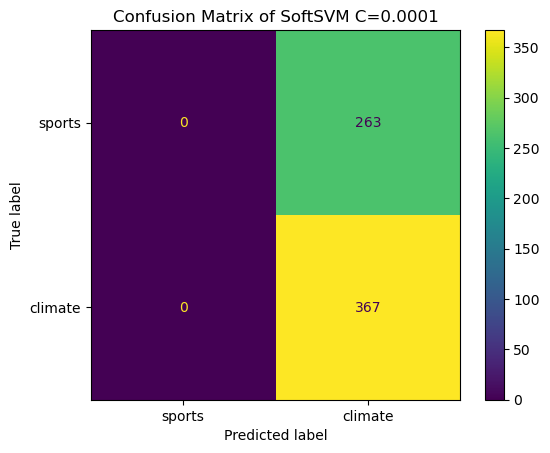

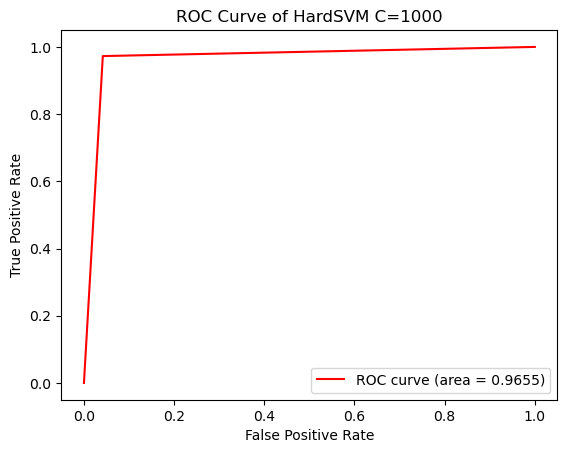

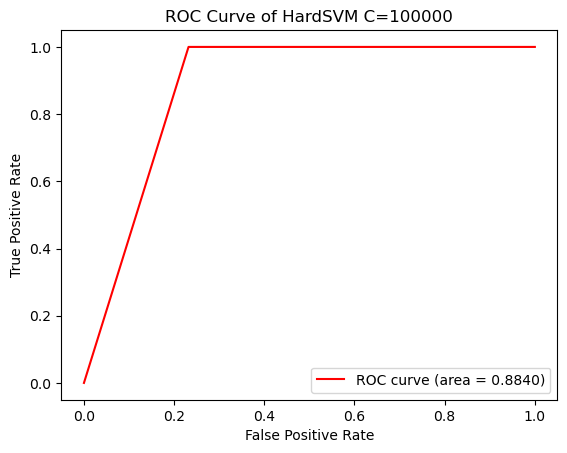

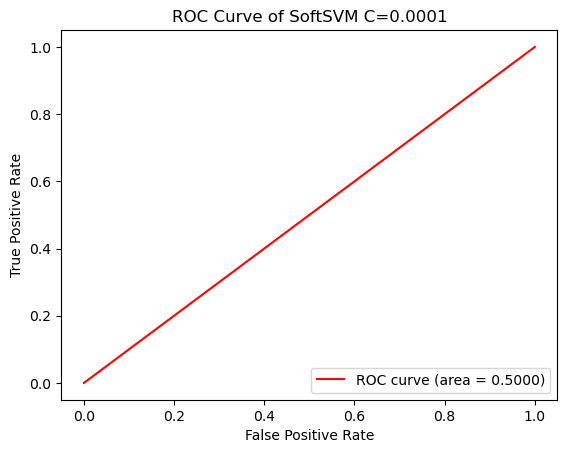

In [27]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc

def my_plot_confusion_matrix(y_true,y_pred,title): 
    cm = confusion_matrix(y_true,y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['sports', 'climate'])
    cmd.plot()
    plt.title(title)
    plt.show()

def my_plot_roc(y_true,y_pred, title): 
    fpr, tpr, _ = roc_curve(y_true,y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = 'r', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

my_plot_confusion_matrix(test_svm_label,X_hardSVM_pred, "Confusion Matrix of HardSVM C=1000")
my_plot_confusion_matrix(test_svm_label,X_hardSVM_pred2, "Confusion Matrix of HardSVM C=100000")
my_plot_confusion_matrix(test_svm_label,X_softSVM_pred, "Confusion Matrix of SoftSVM C=0.0001")

my_plot_roc(test_svm_label, X_hardSVM_pred, "ROC Curve of HardSVM C=1000")
my_plot_roc(test_svm_label, X_hardSVM_pred2,"ROC Curve of HardSVM C=100000")
my_plot_roc(test_svm_label, X_softSVM_pred,"ROC Curve of SoftSVM C=0.0001")

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

location = "cachedir"
memory = Memory(location=location, verbose=10)

cached_pipe = Pipeline(
    [
       ("classify", LinearSVC(dual=False, max_iter=10000)),
    ],
    memory=memory,
)

C_OPTIONS = [10**k for k in range(-3,7,1)]

pipe_parameters = [
    {"classify__C": C_OPTIONS}
]

grid = GridSearchCV(cached_pipe, pipe_parameters, cv=5, n_jobs= -1,verbose = 1)
grid.fit(data_train, train_svm_label)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('classify',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             n_jobs=-1,
             param_grid=[{'classify__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                          10000, 100000, 1000000]}],
             verbose=1)

In [29]:
def print_grid_search_result(grid, param):
    print(grid)
    # print best parameter after tuning
    print(f"grid.best_params_ = {grid.best_params_}" )
    # print how our model looks after hyper-parameter tuning
    print(f"grid.best_estimator_ = {grid.best_estimator_}" )
    print(grid.cv_results_.keys())

    results = pd.DataFrame(grid.cv_results_)[[param,'mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

    param_C = results[param].tolist()
    mean_test_score = round(results.mean_test_score * 100,5).tolist()
    print("=============showing results============")
    for c, m in zip(param_C, mean_test_score):
        print(f"param_C = {c}, mean_test_score = {m}")

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('classify',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             n_jobs=-1,
             param_grid=[{'classify__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                          10000, 100000, 1000000]}],
             verbose=1)
grid.best_params_ = {'classify__C': 1000}
grid.best_estimator_ = Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('classify', LinearSVC(C=1000, dual=False, max_iter=10000))])
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classify__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
=============showing results============
param_C = 1000, mean_

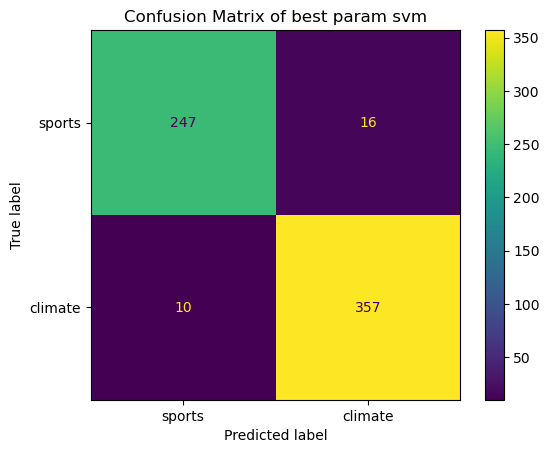

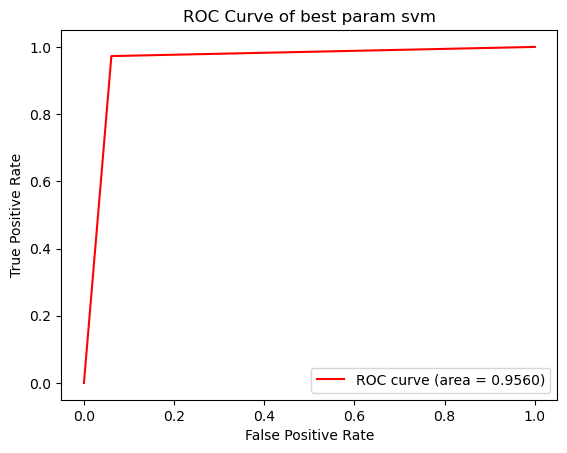

In [30]:
print_grid_search_result(grid, param = 'param_classify__C')

svc_best = LinearSVC(C = grid.best_params_['classify__C'])
svc_best.fit(data_train, train_svm_label)
svc_best_predicted = svc_best.predict(data_test)

print_result(test_svm_label, svc_best_predicted, "result for the best param svm")
my_plot_confusion_matrix(test_svm_label,svc_best_predicted, "Confusion Matrix of best param svm")
my_plot_roc(test_svm_label, svc_best_predicted,"ROC Curve of best param svm")

In [31]:
memory.clear(warn=False)
rmtree(location)

### Question 6

LogisticRegression w/o regularization: accuracy= 95.87, recall= 96.46, precision= 96.46, f1= 96.46


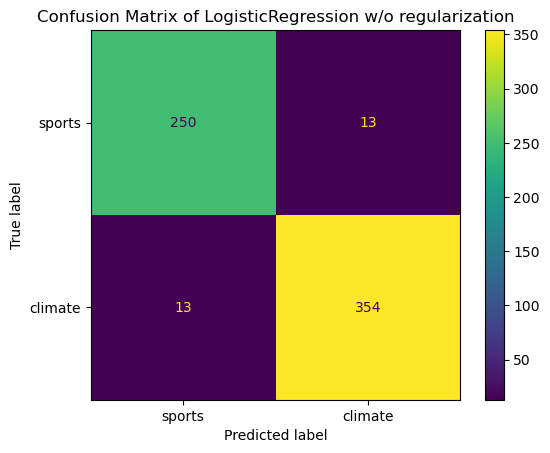

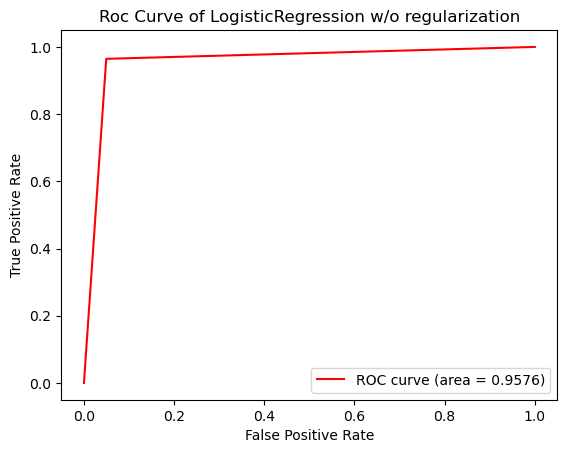

In [32]:
from sklearn.linear_model import LogisticRegression
#without regularization
wo_regularization = LogisticRegression()
wo_regularization.fit(data_train, train_svm_label)
wo_regularization_predicted = wo_regularization.predict(data_test)

print_result(test_svm_label,wo_regularization_predicted, "LogisticRegression w/o regularization")
my_plot_confusion_matrix(test_svm_label,wo_regularization_predicted, "Confusion Matrix of LogisticRegression w/o regularization")
my_plot_roc(test_svm_label,wo_regularization_predicted, "Roc Curve of LogisticRegression w/o regularization")

In [33]:
#  w/ L1 regularization
wl1_pipe_parameters = [
    {'C': [10**k for k in range(-5,6,1)]}
]
wl1_grid = GridSearchCV(LogisticRegression(penalty="l1", solver='liblinear'), wl1_pipe_parameters, cv=5, n_jobs= -1,verbose = 1)
wl1_grid.fit(data_train, train_svm_label)


Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000, 100000]}],
             verbose=1)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000, 100000]}],
             verbose=1)
grid.best_params_ = {'C': 100}
grid.best_estimator_ = LogisticRegression(C=100, penalty='l1', solver='liblinear')
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
=============showing results============
param_C = 100, mean_test_score = 95.59524
param_C = 1000, mean_test_score = 95.59524
param_C = 10000, mean_test_score = 95.55556
param_C = 100000, mean_test_score = 95.55556
param_C = 10, mean_test_score = 95.03968
param_C = 1, mean_test_score = 94.40476
param_C = 0.1, mean_test_score = 92.30159
param_C

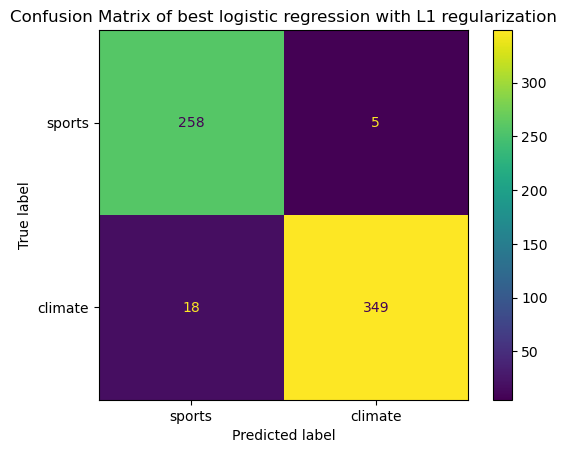

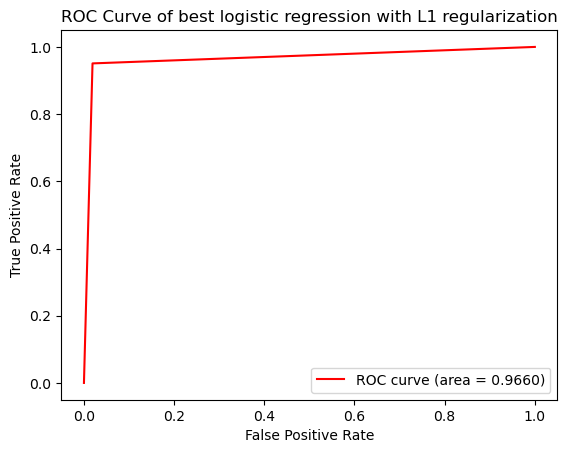

In [34]:
print_grid_search_result(wl1_grid, param = "param_C")

logistic_wl1_best = LogisticRegression(C = wl1_grid.best_params_['C'],penalty="l1", solver='liblinear')
logistic_wl1_best.fit(data_train, train_svm_label)
logistic_wl1_best_predicted = logistic_wl1_best.predict(data_test)

print_result(test_svm_label, logistic_wl1_best_predicted, "result for the best logistic regression with L1 regularization")
my_plot_confusion_matrix(test_svm_label, logistic_wl1_best_predicted, "Confusion Matrix of best logistic regression with L1 regularization")
my_plot_roc(test_svm_label, logistic_wl1_best_predicted, "ROC Curve of best logistic regression with L1 regularization")


In [35]:
#  w/ L2 regularization
wl2_pipe_parameters = [
    {'C': [10**k for k in range(-5,6,1)]}
]
wl2_grid = GridSearchCV(LogisticRegression(penalty="l2", solver='liblinear'), wl2_pipe_parameters, cv=5, n_jobs= -1,verbose = 1)
wl2_grid.fit(data_train, train_svm_label)


Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000, 100000]}],
             verbose=1)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000, 100000]}],
             verbose=1)
grid.best_params_ = {'C': 10000}
grid.best_estimator_ = LogisticRegression(C=10000, solver='liblinear')
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
=============showing results============
param_C = 10000, mean_test_score = 95.59524
param_C = 100000, mean_test_score = 95.55556
param_C = 1000, mean_test_score = 95.39683
param_C = 100, mean_test_score = 94.68254
param_C = 10, mean_test_score = 94.68254
param_C = 1, mean_test_score = 94.12698
param_C = 0.1, mean_test_score = 92.22222
param_C = 0.01, mean_test_score = 72.7381
param_C = 1e-05

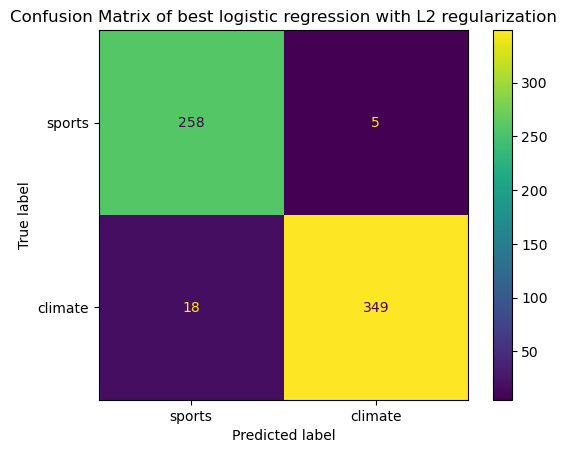

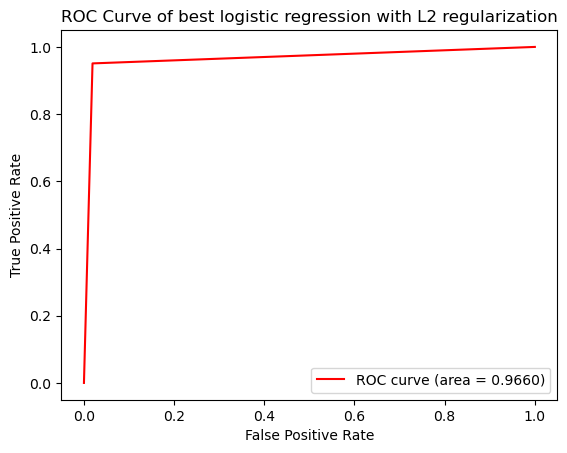

In [36]:
print_grid_search_result(wl2_grid, param = "param_C")

logistic_wl2_best = LogisticRegression(C = wl2_grid.best_params_['C'],penalty="l2", solver='liblinear')
logistic_wl2_best.fit(data_train, train_svm_label)
logistic_wl2_best_predicted = logistic_wl2_best.predict(data_test)

print_result(test_svm_label, logistic_wl2_best_predicted, "result for the best logistic regression with L2 regularization")
my_plot_confusion_matrix(test_svm_label, logistic_wl2_best_predicted, "Confusion Matrix of best logistic regression with L2 regularization")
my_plot_roc(test_svm_label, logistic_wl2_best_predicted, "ROC Curve of best logistic regression with L2 regularization")

### Question 7

GaussianNB result: accuracy= 94.29, recall= 90.74, precision= 99.40, f1= 94.87


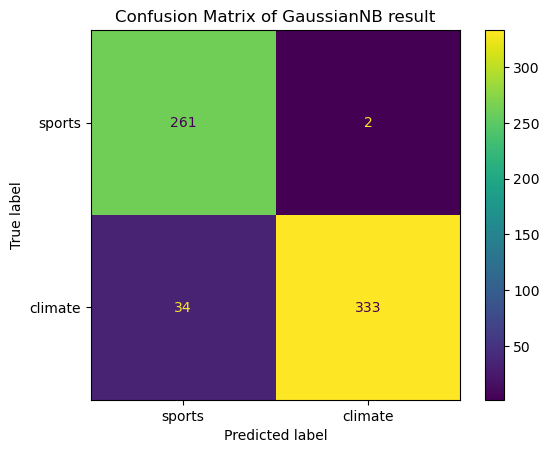

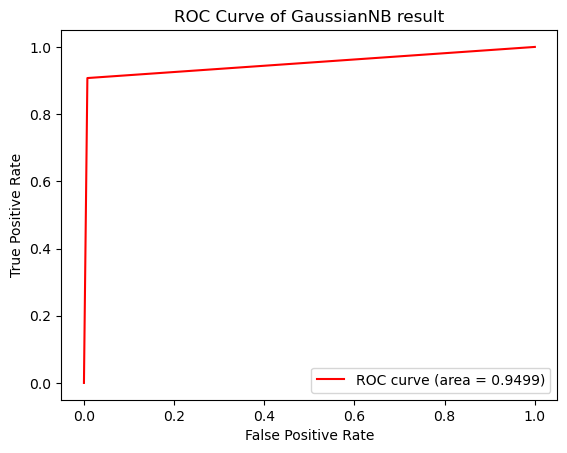

In [37]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(data_train, train_svm_label)
pred = gnb.predict(data_test)
print_result(test_svm_label, pred, "GaussianNB result")
my_plot_confusion_matrix(test_svm_label, pred, "Confusion Matrix of GaussianNB result")
my_plot_roc(test_svm_label, pred, "ROC Curve of GaussianNB result")

### Question 8

In [38]:
# step 1 Loading data whether clean data or not

# step 2 
# min_df = 3  vs  5
# lemmatized  vs  stemming

# step3
# LSI (k = [5, 30, 80]) vs NMF (k = [5, 30, 80])

# step4
# SVM with the best γ previously found 
# vs
# Logistic Regression: L1 regularization vs L2 regularization,
# with the best regularization strength previously found
# vs
# GaussianNB

# Create a temporary folder to store the transformers of the pipeline
location = "cachedir"
memory = Memory(location=location, verbose=10)

cached_pipe = Pipeline(
    [
        ("countvector", CountVectorizer(stop_words='english')),
        ("tfidf", TfidfTransformer(use_idf = True)),
        ("reduce_dim", "passthrough"),
        ("classifier", None)
    ],
    memory=memory,
)

N_FEATURES_OPTIONS = [5, 30, 80]
param_grid = [
    {
        "countvector__min_df": (3,5),
        "reduce_dim": [TruncatedSVD(random_state=42), NMF(random_state=42,max_iter=10000)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        'classifier': (
            LinearSVC(C=grid.best_params_['classify__C'],random_state=42),
            LogisticRegression(penalty='l1',C=wl1_grid.best_params_['C'],random_state=42,solver='liblinear'),
            LogisticRegression(penalty='l2',C=wl2_grid.best_params_['C'],random_state=42,solver='liblinear'),
            GaussianNB(),
        ),  
    }
]

In [39]:
def _print_gridsearch_result(model, title):
    print(model.cv_results_.keys())
    print(f"Best estimator for {title}: ", model.best_estimator_)
    print(f"Best parameters for {title}: ", model.best_params_)
    print(f"Best score for {title}: ", model.best_score_)

In [40]:
train['clean_data'] = train['full_text'].progress_apply(lambda x:clean_data(x))
test['clean_data'] = test['full_text'].progress_apply(lambda x:clean_data(x))

train['un_clean_data'] = train['full_text']
test['un_clean_data'] = test['full_text']


#processing with clean data
clean_stem = train['clean_data'].progress_apply(lambda x:stem(x))
clean_lemmatized= train['clean_data'].progress_apply(lambda x:lemmatized(x))

un_clean_stem = train['un_clean_data'] .progress_apply(lambda x:stem(x))
un_clean_lemmatized= train['un_clean_data'] .progress_apply(lambda x:lemmatized(x))

100%|██████████| 2520/2520 [01:19<00:00, 31.69it/s]


In [41]:
# clean data with lemmatization
grid_clean_lemmatized = GridSearchCV(cached_pipe, param_grid = param_grid, cv = 5, scoring = 'accuracy', verbose = 5, n_jobs = -1)
grid_clean_lemmatized.fit(clean_lemmatized, train_svm_label)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=5, stop_words='english'), 2310    of sunday night a lopsided area of low pressur...
2189    childrens agency say some million child in are...
2304    wind and heavy rain batter the state of maine ...
2988    i live in a community with a homeowner associa...
221     special olympics team take home the hard fough...
                              ...                        
3092    coachella valley homeowner and community be sa...
1095    photo gerard pique retire from soccer this pas...
1130    much of your donate clothing find a new home o...
1294    tennessee state football team fell out of cont...
860     starnews this feature be sponsor by service co...
Name: clean_data, Length: 2520, dtype: object, 
array([0, ..., 1], dtype=int64), None, message_

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('countvector',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classifier', None)]),
             n_jobs=-1,
             param_grid=[{'classifier': (LinearSVC(C=1000, random_state=42),
                                         LogisticRegression(C=100, penalty='l1',
                                                            random_state=42,
                                                            solver='liblinear'),
                                         LogisticRegression(C=10000,
                                                            random_state=42,
                                                            solver='liblinear'),
   

In [42]:
_print_gridsearch_result(grid_clean_lemmatized, "clean data with lemmatization")

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_countvector__min_df', 'param_reduce_dim', 'param_reduce_dim__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best estimator for clean data with lemmatization:  Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('countvector',
                 CountVectorizer(min_df=5, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim',
                 NMF(max_iter=10000, n_components=80, random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Best parameters for clean data with lemmatization:  {'classifier': LogisticRegression(C=100, penalty='l1', random_state=42, solve

In [43]:
memory.clear(warn=False)
rmtree(location)

In [44]:
# clean data with stemming
grid_clean_stem= GridSearchCV(cached_pipe, param_grid = param_grid, cv = 5, scoring = 'accuracy', verbose = 5, n_jobs = -1)
grid_clean_stem.fit(clean_stem, train_svm_label)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 2310    of sunday night a lopsid area of low pressur i...
2189    children agenc say some million children in ar...
2304    wind and heavi rain batter the state of main a...
2988    i live in a commun with a homeown associ where...
221     special olymp team took home the hard fought v...
                              ...                        
3092    coachella valley homeown and commun are save w...
1095    photo gerard piqu retir from soccer thi past w...
1130    much of your donat cloth find a new home or he...
1294    tennesse state footbal team fell out of conten...
860     starnew thi featur is sponsor by servic compan...
Name: clean_data, Length: 2520, dtype: object, 
array([0, ..., 1], dtype=int64), None, message_

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('countvector',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classifier', None)]),
             n_jobs=-1,
             param_grid=[{'classifier': (LinearSVC(C=1000, random_state=42),
                                         LogisticRegression(C=100, penalty='l1',
                                                            random_state=42,
                                                            solver='liblinear'),
                                         LogisticRegression(C=10000,
                                                            random_state=42,
                                                            solver='liblinear'),
   

In [45]:
_print_gridsearch_result(grid_clean_stem, "clean data with stemming")

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_countvector__min_df', 'param_reduce_dim', 'param_reduce_dim__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best estimator for clean data with stemming:  Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('countvector',
                 CountVectorizer(min_df=3, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim',
                 NMF(max_iter=10000, n_components=80, random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Best parameters for clean data with stemming:  {'classifier': LogisticRegression(C=100, penalty='l1', random_state=42, solver='libline

In [46]:
memory.clear(warn=False)
rmtree(location)

In [47]:
# not clean data with lemmatization
grid_un_clean_lemmatized = GridSearchCV(cached_pipe, param_grid = param_grid, cv = 5, scoring = 'accuracy', verbose = 5, n_jobs = -1)
grid_un_clean_lemmatized.fit(un_clean_lemmatized, train_svm_label)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 2310    of sunday night a lopsided area of low pressur...
2189    child ’ s agency say some 2 million child in a...
2304    wind and heavy rain batter the state of maine ...
2988    i live in a community with a homeowner associa...
221     special olympics team take home the hard fough...
                              ...                        
3092    coachella valley homeowner and community be sa...
1095    photo 4851709 gerard pique retire from soccer ...
1130    much of your donate clothing find a new home o...
1294    tennessee state football team fell out of cont...
860     starnews this feature be sponsor by service co...
Name: un_clean_data, Length: 2520, dtype: object, 
array([0, ..., 1], dtype=int64), None, messa

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('countvector',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classifier', None)]),
             n_jobs=-1,
             param_grid=[{'classifier': (LinearSVC(C=1000, random_state=42),
                                         LogisticRegression(C=100, penalty='l1',
                                                            random_state=42,
                                                            solver='liblinear'),
                                         LogisticRegression(C=10000,
                                                            random_state=42,
                                                            solver='liblinear'),
   

In [48]:
_print_gridsearch_result(grid_un_clean_lemmatized, "unclean data with lemmatization")

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_countvector__min_df', 'param_reduce_dim', 'param_reduce_dim__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best estimator for unclean data with lemmatization:  Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('countvector',
                 CountVectorizer(min_df=3, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim', TruncatedSVD(n_components=80, random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Best parameters for unclean data with lemmatization:  {'classifier': LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear'), 'cou

In [49]:
memory.clear(warn=False)
rmtree(location)

In [50]:
# not clean data with stemming
grid_un_clean_stem = GridSearchCV(cached_pipe, param_grid = param_grid, cv = 5, scoring = 'accuracy', verbose = 5, n_jobs = -1)
grid_un_clean_stem.fit(un_clean_stem, train_svm_label)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 2310    of sunday night a lopsid area of low pressur i...
2189    children ’ s agenc say some 2 million children...
2304    wind and heavi rain batter the state of main a...
2988    i live in a commun with a homeown associ where...
221     special olymp team took home the hard fought v...
                              ...                        
3092    coachella valley homeown and commun are save w...
1095    photo 4851709 gerard piqu retir from soccer th...
1130    much of your donat cloth find a new home or he...
1294    tennesse state footbal team fell out of conten...
860     starnew thi featur is sponsor by servic compan...
Name: un_clean_data, Length: 2520, dtype: object, 
array([0, ..., 1], dtype=int64), None, messa

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('countvector',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classifier', None)]),
             n_jobs=-1,
             param_grid=[{'classifier': (LinearSVC(C=1000, random_state=42),
                                         LogisticRegression(C=100, penalty='l1',
                                                            random_state=42,
                                                            solver='liblinear'),
                                         LogisticRegression(C=10000,
                                                            random_state=42,
                                                            solver='liblinear'),
   

In [51]:
_print_gridsearch_result(grid_un_clean_stem, "unclean data with stemming")

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier', 'param_countvector__min_df', 'param_reduce_dim', 'param_reduce_dim__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best estimator for unclean data with stemming:  Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('countvector',
                 CountVectorizer(min_df=3, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim',
                 NMF(max_iter=10000, n_components=80, random_state=42)),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Best parameters for unclean data with stemming:  {'classifier': LogisticRegression(C=100, penalty='l1', random_state=42, solver='lib

In [52]:
memory.clear(warn=False)
rmtree(location)

## 5 Multiclass Classification
### Question 9

In [53]:
df = pd.read_csv("Project1-Classification.csv")
train_leaf, test_leaf = train_test_split(df[["full_text", "leaf_label"]], test_size = 0.2)
print("Train Shape: ", train_leaf.shape, " --- Test Shape: ", test_leaf.shape)

Train Shape:  (2520, 2)  --- Test Shape:  (630, 2)


In [54]:
train_leaf['clean_data'] = train_leaf['full_text'].progress_apply(lambda x:preprocessing(x))

100%|██████████| 2520/2520 [01:22<00:00, 30.58it/s]


In [55]:
test_leaf['clean_data'] = test_leaf['full_text'].progress_apply(lambda x:preprocessing(x))

100%|██████████| 630/630 [00:19<00:00, 33.13it/s]


In [56]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=3)
tfidf_tranformer = TfidfTransformer(use_idf=True)

train_leaf_count_vectorizer = count_vectorizer.fit_transform(train_leaf['clean_data'])
train_leaf_tf_idf3 = tfidf_tranformer.fit_transform(train_leaf_count_vectorizer).toarray()
print('train matrix shape:', train_leaf_tf_idf3.shape)

test_leaf_count_vectorizer = count_vectorizer.transform(test_leaf['clean_data'])
test_leaf_tf_idf3 = tfidf_tranformer.transform(test_leaf_count_vectorizer).toarray()
print('test matrix shape:', test_leaf_tf_idf3.shape)

train matrix shape: (2520, 14198)
test matrix shape: (630, 14198)


In [57]:
map_row_to_class = {0:"chess", 1:"cricket", 2:"hockey", 3:"soccer", 4:"football", 5:"%22forest%20fire%22", 6:"flood", 7:"earthquake", 8:"drought"}

maps= {value: key for key, value in map_row_to_class.items()}

classes = list(maps.keys())
# print(classes)

lsi_leaf = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
data_train_leaf = lsi_leaf.fit_transform(train_leaf_tf_idf3)
data_test_leaf = lsi_leaf.transform(test_leaf_tf_idf3)

print(data_train_leaf.shape, data_test_leaf.shape)

train_svm_leaf = train_leaf
train_svm_leaf = train_svm_leaf.replace({'leaf_label': maps})
train_svm_leaf_label = train_svm_leaf['leaf_label'].to_numpy()
print(f"train_svm_leaf_label shape={train_svm_leaf_label.shape}")

test_svm_leaf = test_leaf
test_svm_leaf = test_svm_leaf.replace({'leaf_label': maps})
test_svm_leaf_label = test_svm_leaf['leaf_label'].to_numpy()
print(f"test_svm_leaf_label shape={test_svm_leaf_label.shape}")

(2520, 50) (630, 50)
train_svm_leaf_label shape=(2520,)
test_svm_leaf_label shape=(630,)


In [58]:
import seaborn as sns

def my_plot_multi_confusion_matrix(y_true,y_pred,title,classes): 
    cm = confusion_matrix(y_true,y_pred)
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

    sns.heatmap(cm_df, annot=True)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [59]:
def compare_svm_multiclass(model, train_data, test_data, train_label, test_label, classes, result_title, confusion_matrix_title):
    model.fit(train_data, train_label)
    pred = model.predict(test_data)
 
    print_result(test_label, pred, result_title, average='micro')
    my_plot_multi_confusion_matrix(test_label, pred, confusion_matrix_title, classes)


One VS One SVM: accuracy= 76.35, recall= 76.35, precision= 76.35, f1= 76.35


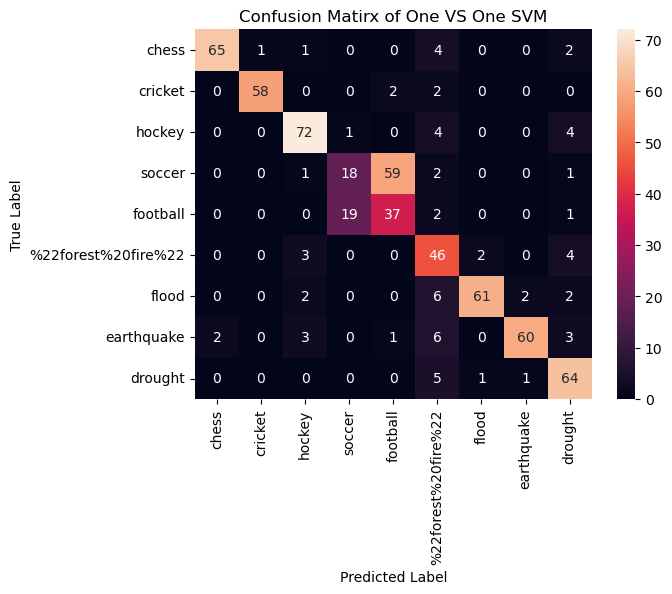

In [60]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

#svm one VS one
multiclass_svm_OvO = OneVsOneClassifier(SVC(random_state=42, class_weight="balanced"))
compare_svm_multiclass(multiclass_svm_OvO , data_train_leaf , data_test_leaf, train_svm_leaf_label, test_svm_leaf_label, classes, "One VS One SVM", "Confusion Matirx of One VS One SVM")

One VS Rest SVM: accuracy= 77.78, recall= 77.78, precision= 77.78, f1= 77.78


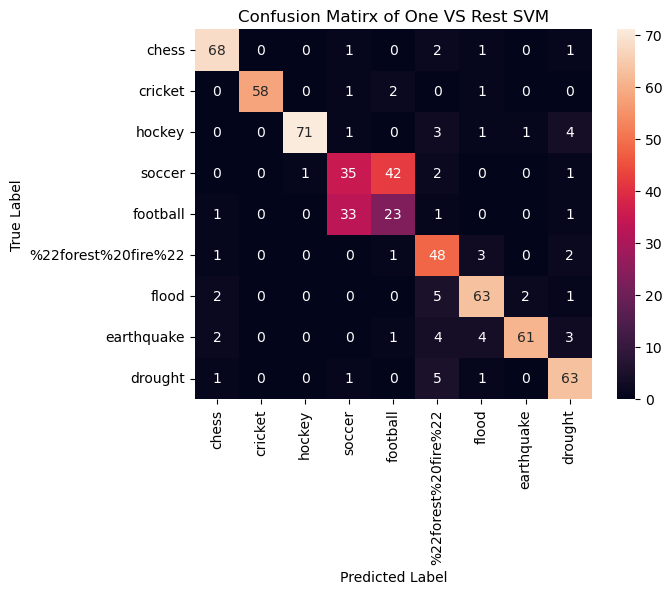

In [61]:
#svm one VS rest
multiclass_svm_OvR = OneVsRestClassifier(SVC(random_state=42, class_weight="balanced"))
compare_svm_multiclass(multiclass_svm_OvR , data_train_leaf , data_test_leaf, train_svm_leaf_label, test_svm_leaf_label, classes, "One VS Rest SVM", "Confusion Matirx of One VS Rest SVM")

native bayes classification: accuracy= 71.90, recall= 71.90, precision= 71.90, f1= 71.90


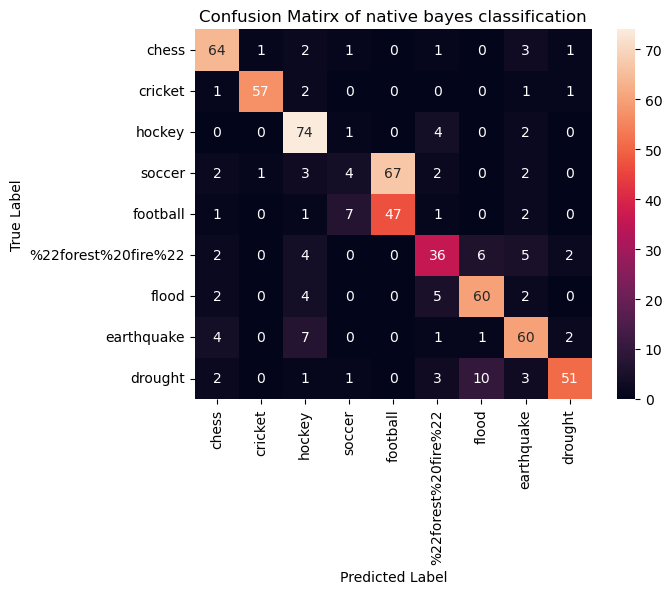

In [62]:
#native bayes classification
gnb = GaussianNB()
compare_svm_multiclass(gnb , data_train_leaf , data_test_leaf, train_svm_leaf_label, test_svm_leaf_label, classes, "native bayes classification", "Confusion Matirx of native bayes classification")

In [63]:
def transfer_map(m, 
    transfer_key = lambda x : x if x <= 3 else x - 1,
    transfer_value = lambda x : 'soccer & football' if x == "soccer" else x,
    drop_kv = lambda k,v : True if v == "football" else False):
    new_m = {}
    for k, v in m.items():
        if drop_kv(k, v):
            continue
        new_m[transfer_value(v)] = transfer_key(k)
    return new_m

In [64]:
# due to the results above, we decide to merge soccer with football and soccer

new_map_row_to_class = {'chess': 0, 'cricket': 1, 'hockey': 2, 'soccer': 3, 'football': 3, '%22forest%20fire%22': 4, 'flood': 5, 'earthquake': 6, 'drought': 7}
new_map_class_to_row = {0: 'chess', 1: 'cricket', 2: 'hockey', 3: 'soccer and football', 4: '%22forest%20fire%22', 5: 'flood', 6: 'earthquake', 7: 'drought'}

print(new_map_row_to_class)

merged_classes = list(new_map_class_to_row.values())
print(merged_classes)

lsi_merged_leaf = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
data_train_merged_leaf = lsi_merged_leaf.fit_transform(train_leaf_tf_idf3)
data_test_merged_leaf = lsi_merged_leaf.transform(test_leaf_tf_idf3)

print(data_train_merged_leaf.shape, data_test_merged_leaf.shape)

train_svm_merged_leaf = train_leaf
train_svm_merged_leaf = train_svm_merged_leaf.replace({'leaf_label': new_map_row_to_class})
train_svm_merged_leaf_label = train_svm_merged_leaf['leaf_label'].to_numpy()
print(f"train_svm_merged_leaf_label shape={train_svm_merged_leaf_label.shape}")

test_svm_merged_leaf = test_leaf
test_svm_merged_leaf = test_svm_merged_leaf.replace({'leaf_label': new_map_row_to_class})
test_svm_merged_leaf_label = test_svm_merged_leaf['leaf_label'].to_numpy()
print(f"test_svm_merged_leaf_label shape={test_svm_merged_leaf_label.shape}")

{'chess': 0, 'cricket': 1, 'hockey': 2, 'soccer': 3, 'football': 3, '%22forest%20fire%22': 4, 'flood': 5, 'earthquake': 6, 'drought': 7}
['chess', 'cricket', 'hockey', 'soccer and football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought']
(2520, 50) (630, 50)
train_svm_merged_leaf_label shape=(2520,)
test_svm_merged_leaf_label shape=(630,)


One VS One SVM of merged leaf: accuracy= 88.57, recall= 88.57, precision= 88.57, f1= 88.57


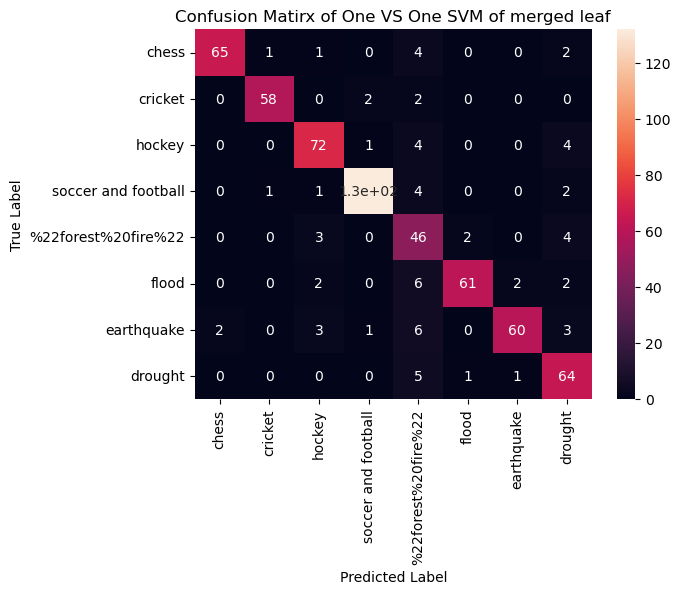

In [65]:
#svm one VS one merged_leaf
multiclass_svm_OvO_merged = OneVsOneClassifier(SVC(random_state=42, class_weight="balanced"))
compare_svm_multiclass(multiclass_svm_OvO_merged , data_train_merged_leaf, data_test_merged_leaf, train_svm_merged_leaf_label, test_svm_merged_leaf_label , merged_classes, "One VS One SVM of merged leaf", "Confusion Matirx of One VS One SVM of merged leaf")

One VS One SVM of merged leaf: accuracy= 89.68, recall= 89.68, precision= 89.68, f1= 89.68


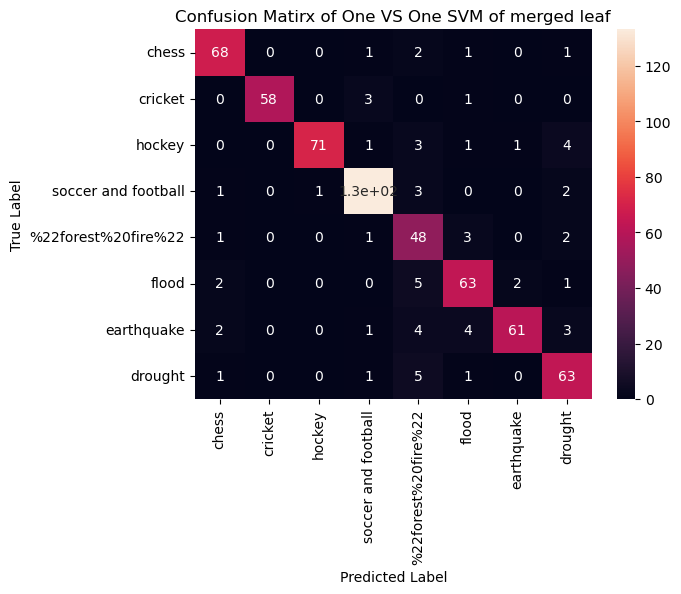

In [66]:
#svm one VS one merged_leaf
multiclass_svm_OvR_merged = OneVsRestClassifier(SVC(random_state=42, class_weight="balanced"))
compare_svm_multiclass(multiclass_svm_OvR_merged , data_train_merged_leaf, data_test_merged_leaf, train_svm_merged_leaf_label, test_svm_merged_leaf_label , merged_classes, "One VS One SVM of merged leaf", "Confusion Matirx of One VS One SVM of merged leaf")

native bayes classification: accuracy= 83.49, recall= 83.49, precision= 83.49, f1= 83.49


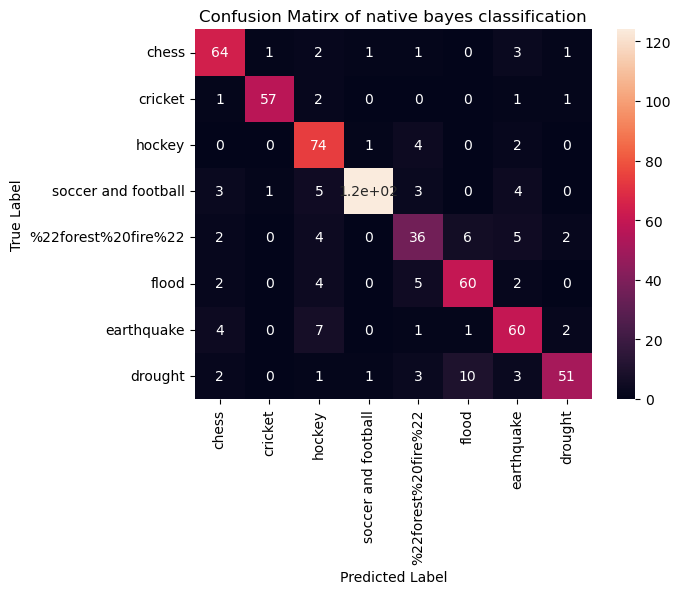

In [67]:
#native bayes classification merged_leaf
gnb_merged = GaussianNB()
compare_svm_multiclass(gnb_merged, data_train_merged_leaf, data_test_merged_leaf, train_svm_merged_leaf_label, test_svm_merged_leaf_label , merged_classes,"native bayes classification", "Confusion Matirx of native bayes classification")

One VS One SVM of merged leaf Unbalanced: accuracy= 88.57, recall= 88.57, precision= 88.57, f1= 88.57


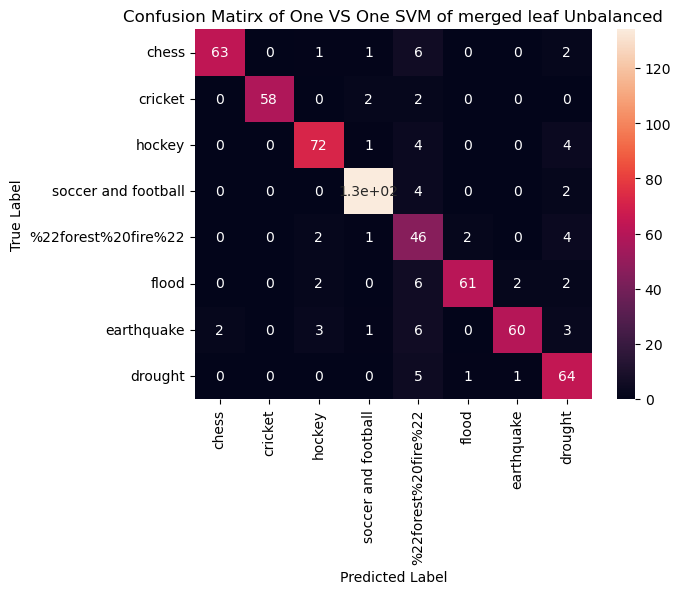

In [68]:
#svm one VS one merged_leaf unbalanced
multiclass_svm_OvO_merged_unbalanced = OneVsOneClassifier(SVC(random_state=42))
compare_svm_multiclass(multiclass_svm_OvO_merged_unbalanced, data_train_merged_leaf, data_test_merged_leaf, train_svm_merged_leaf_label, test_svm_merged_leaf_label , merged_classes, "One VS One SVM of merged leaf Unbalanced", "Confusion Matirx of One VS One SVM of merged leaf Unbalanced")

One VS Rest SVM of merged leaf Unbalanced: accuracy= 90.95, recall= 90.95, precision= 90.95, f1= 90.95


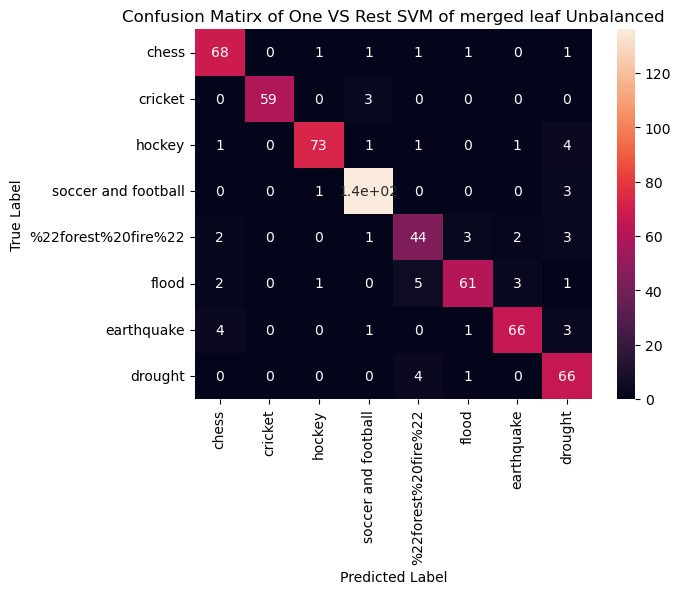

In [69]:
#svm one VS rest merged_leaf unbalanced
multiclass_svm_OvR_merged_unbalanced = OneVsRestClassifier(SVC(random_state=42))
compare_svm_multiclass(multiclass_svm_OvR_merged_unbalanced, data_train_merged_leaf, data_test_merged_leaf, train_svm_merged_leaf_label, test_svm_merged_leaf_label , merged_classes, "One VS Rest SVM of merged leaf Unbalanced", "Confusion Matirx of One VS Rest SVM of merged leaf Unbalanced")

### Question 10

In [70]:
import numpy as np

In [71]:
embeddings_dict = {}

dimension_of_glove = 300

with open("glove/glove.6B.300d.txt", 'rb') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [72]:
print(np.linalg.norm(embeddings_dict[b'queen']-embeddings_dict[b'king']-embeddings_dict[b'wife']+embeddings_dict[b'husband']))
print(np.linalg.norm(embeddings_dict[b'queen']-embeddings_dict[b'king']))
print(np.linalg.norm(embeddings_dict[b'wife']-embeddings_dict[b'husband']))

6.165036
5.966258
3.1520464


### Question 11

In [23]:
embeddings_dict = {}

dimension_of_glove = 300

with open("glove/glove.6B.300d.txt", 'rb') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0].decode()
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [25]:
df = pd.read_csv("./Project1-Classification.csv")

train_glove, test_glove = train_test_split(df[["full_text", "root_label","keywords"]], test_size = 0.2)

maps = {'sports': 1, 'climate': 0}

In [26]:
train_data_glove = train_glove
train_data_glove = train_data_glove.replace({'root_label': maps})
train_data_glove_label = train_data_glove['root_label'].to_numpy()

test_data_glove = test_glove
test_data_glove = test_data_glove.replace({'root_label': maps})
test_data_glove_label = test_data_glove['root_label'].to_numpy()

In [27]:
def print_result2(y_true,y_pred,name="",average='binary'):
    accuracy, recall, precision, f1 = accuracy_score(y_true,y_pred) * 100, recall_score(y_true,y_pred,average=average)*100, \
                                       precision_score(y_true,y_pred,average=average)*100, f1_score(y_true,y_pred,average=average)*100
    print("%s: accuracy= %.2f, recall= %.2f, precision= %.2f, f1= %.2f" %(name,accuracy, recall, precision, f1))
    return [accuracy, recall, precision, f1]

In [28]:
# transfer wordlist to embedding
confuseWords = set()
def wordListToEmbeddng(wordlist, glove_dim):
    init_embedding, wordLen = np.zeros(glove_dim), 0
    for word in wordlist:
        if word not in embeddings_dict:
            confuseWords.add(word)
            continue
        init_embedding += embeddings_dict[word]
        wordLen += 1
    init_embedding /= wordLen
    return init_embedding.tolist()

def train_model(train_df, test_df, model, model_name):
    train_df["embedding"] = train_df['keywords'].apply(lambda x: wordListToEmbeddng(eval(x), 300))
    test_df["embedding"] = test_df['keywords'].apply(lambda x: wordListToEmbeddng(eval(x), 300))
    model.fit(np.array(train_df["embedding"].tolist()), train_df["root_label"].to_numpy())
    test_predict = model.predict(np.array(test_df["embedding"].tolist()))
    result = print_result2(test_predict, test_df["root_label"], "The HardMargin_SVM result for average glove embedding")
    return model,result


In [29]:
model, model_name = LinearSVC(C=1000, random_state=42), "HardMargin_SVM"
model, result = train_model(train_data_glove, test_data_glove, model, model_name)

The HardMargin_SVM result for average glove embedding: accuracy= 93.81, recall= 93.16, precision= 96.46, f1= 94.78


In [30]:
dim_embeddings_dict = {}
dim_embeddings_dict[300] = embeddings_dict
for dim in [50, 100, 200]:
    dim_embeddings_dict[dim] = {}
    print(f"now loading glove dim = {dim}")
    with open(f"glove/glove.6B.{dim}d.txt", 'rb') as f: # if 'r' fails with unicode error, please use 'rb'
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.asarray(values[1:], "float32")
            dim_embeddings_dict[dim][word] = vector

now loading glove dim = 50
now loading glove dim = 100
now loading glove dim = 200


In [31]:
# transfer wordlist to embedding
confuseWords = set()
def wordListToEmbeddng(wordlist, glove_dim = 300):
    init_embedding, wordLen = np.zeros(glove_dim), 0
    for word in wordlist:
        if word not in dim_embeddings_dict[glove_dim]:
            confuseWords.add(word)
            continue
        init_embedding += dim_embeddings_dict[glove_dim][word]
        wordLen += 1
    init_embedding /= wordLen
    return init_embedding.tolist()

def train_model(train_df, test_df, model, model_name, glove_dim = 300):
    train_df["embedding"] = train_df['keywords'].apply(lambda x: wordListToEmbeddng(eval(x), glove_dim))
    test_df["embedding"] = test_df['keywords'].apply(lambda x: wordListToEmbeddng(eval(x), glove_dim))
    model.fit(np.array(train_df["embedding"].tolist()), train_df["root_label"].to_numpy())
    test_predict = model.predict(np.array(test_df["embedding"].tolist()))
    result = print_result2(test_predict, test_df["root_label"], model_name)
    return model,result


### Question12

In [32]:
results = []
dims = [50, 100, 200, 300]
for dim in dims:
    model, model_name = LinearSVC(C=1000, random_state=42), f"HardMargin_SVM_{dim}"
    model,result = train_model(train_data_glove, test_data_glove, model, model_name, dim)
    results.append(result)

HardMargin_SVM_50: accuracy= 96.19, recall= 95.73, precision= 97.82, f1= 96.77
HardMargin_SVM_100: accuracy= 94.92, recall= 93.28, precision= 98.37, f1= 95.76
HardMargin_SVM_200: accuracy= 93.49, recall= 92.89, precision= 96.19, f1= 94.51
HardMargin_SVM_300: accuracy= 93.81, recall= 93.16, precision= 96.46, f1= 94.78


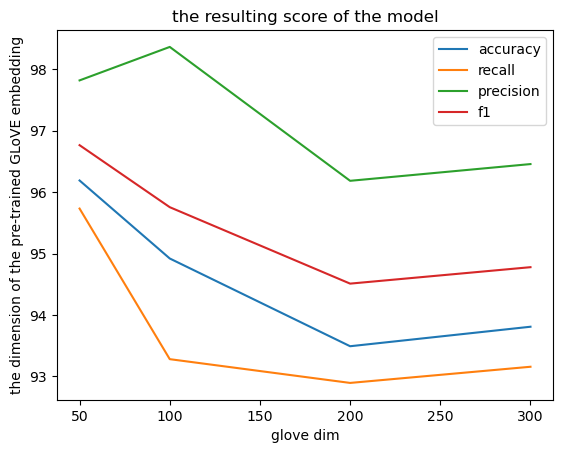

In [38]:
acc = []
rec = []
pre = []
f1_ = []

for result in results:
    acc.append(result[0])
    rec.append(result[1])
    pre.append(result[2])
    f1_.append(result[3])

plt.plot(dims, acc, label = "accuracy")
plt.plot(dims, rec, label = "recall")
plt.plot(dims, pre, label = "precision")
plt.plot(dims, f1_, label = "f1")

plt.xlabel('glove dim')
plt.ylabel('the dimension of the pre-trained GLoVE embedding')
plt.title('the resulting score of the model')
plt.legend()
    
plt.show()


In [35]:
from sklearn.preprocessing import StandardScaler
import pickle

rmaps = {1: 'sports', 0: 'climate'}
train_data_glove = train_data_glove.replace({'root_label': rmaps})
labels = np.array(train_data_glove["root_label"].tolist())

for dim in [50, 100, 200, 300]:
    em = dim_embeddings_dict[dim]
    train_data_glove["embedding"] = train_data_glove['keywords'].apply(lambda x: wordListToEmbeddng(eval(x), dim))
    # test_data_glove["embedding"] = test_data_glove['keywords'].apply(lambda x: wordListToEmbeddng(eval(x), dim))
    scaled_embedding = StandardScaler().fit_transform(np.array(train_data_glove["embedding"].tolist()))
    print(scaled_embedding.shape)
    filename = f"scaled_embedding_labels_dim{dim}"
    with open(filename, "wb") as f:
        pickle.dump((scaled_embedding, labels), f)

(2520, 50)
(2520, 100)
(2520, 200)
(2520, 300)


### Question13

In [1]:
def uplot_embedding_labels(filename):
    scaled_embedding_label = None
    with open(filename, "rb") as f:
        scaled_embedding_label = pickle.load(f)
    embedding, label = scaled_embedding_label
    print(embedding.shape, label.shape)
    u_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(embedding)
    f = uplot.points(u_embedding, labels=label, theme='fire')
    plt.title(filename.split("_")[-1] + "glove_embedding")
    plt.show()

    random_embedding = np.random.rand(*embedding.shape)
    rand_u_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(random_embedding)
    f = uplot.points(rand_u_embedding, labels=label, theme='fire')
    plt.title(filename.split("_")[-1] + "random_embedding")
    plt.show()

(2520, 50) (2520,)


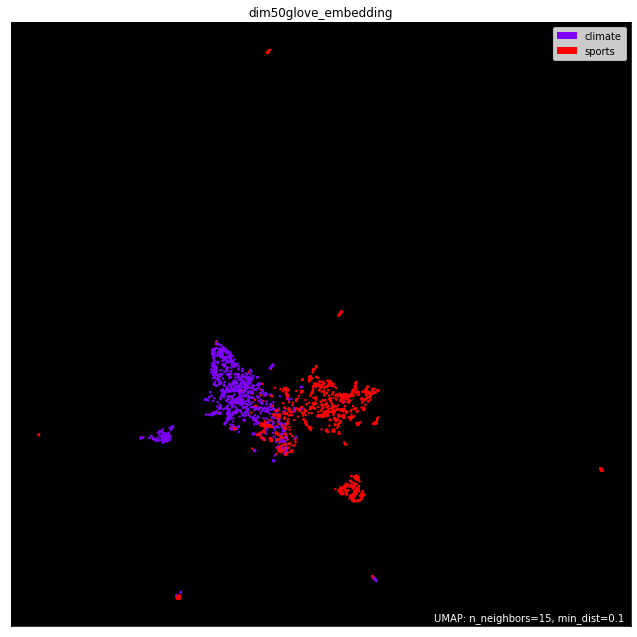

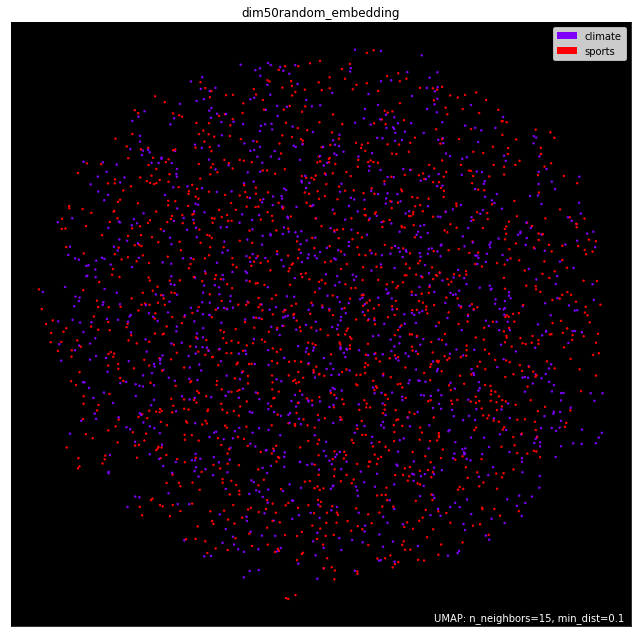

In [33]:
uplot_embedding_labels("scaled_embedding_labels_dim50")

(2520, 100) (2520,)


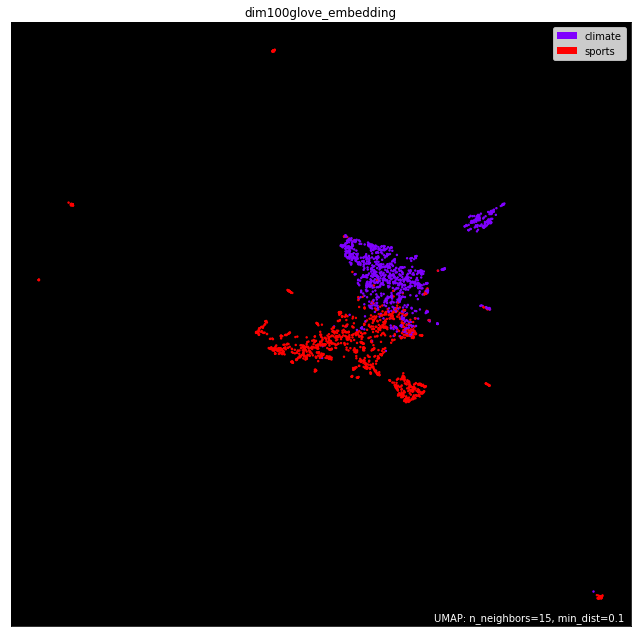

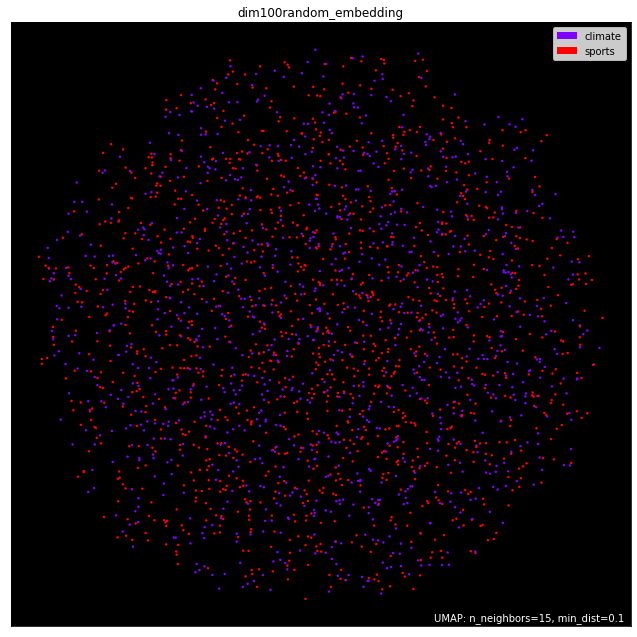

In [34]:
uplot_embedding_labels("scaled_embedding_labels_dim100")

(2520, 200) (2520,)


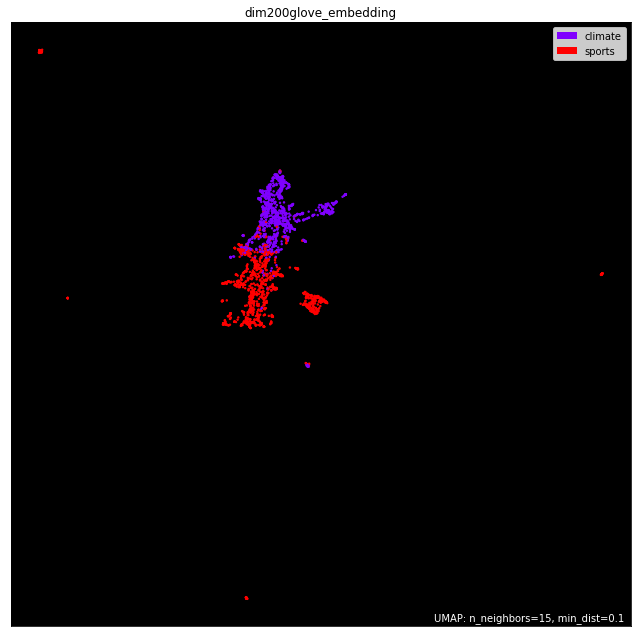

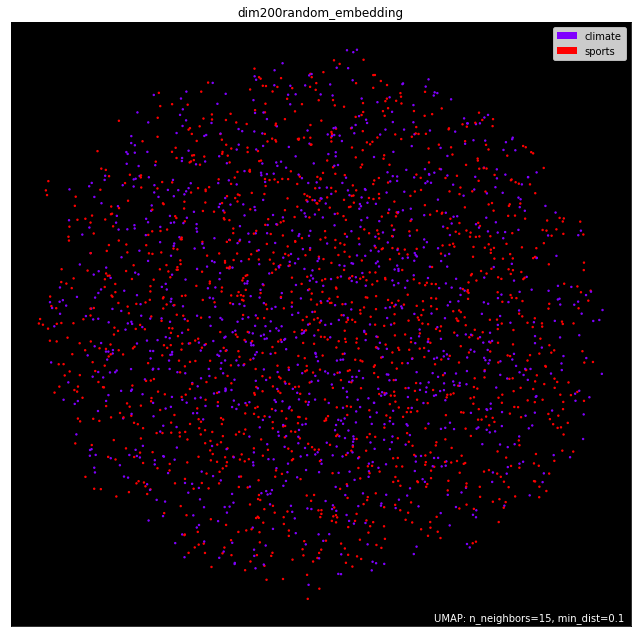

In [35]:
uplot_embedding_labels("scaled_embedding_labels_dim200")

(2520, 300) (2520,)


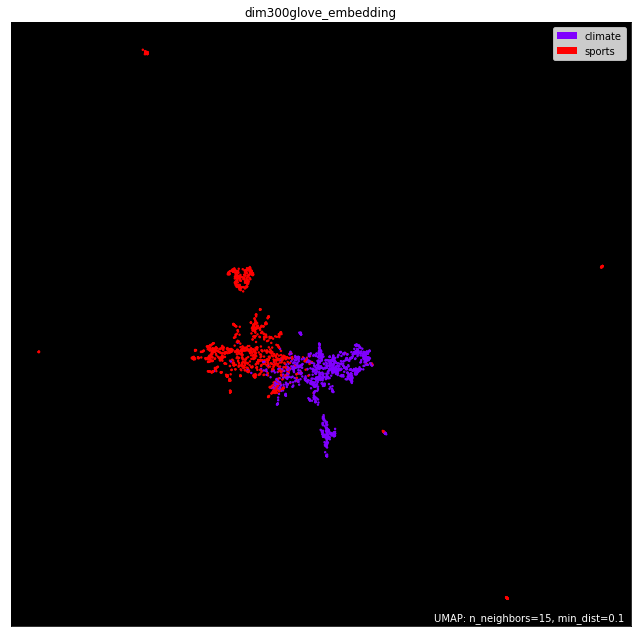

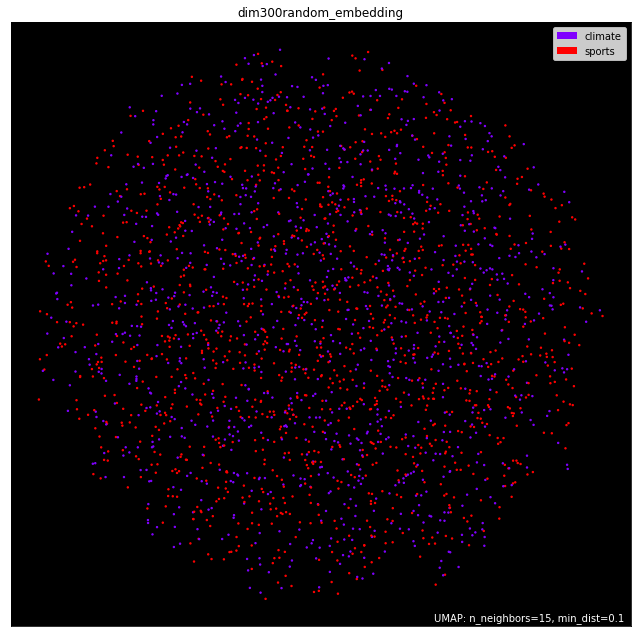

In [36]:
uplot_embedding_labels("scaled_embedding_labels_dim300")